In [1]:
import jax.numpy as jnp
import jax
import matplotlib.pyplot as plt
import numpy as np
import os
import trimesh
import b3d
from jax.scipy.spatial.transform import Rotation as Rot
from b3d import Pose
from b3d.utils import unproject_depth
import rerun as rr


In [2]:
rr.init("demo.py")
rr.connect("127.0.0.1:8812")

[2024-04-12T19:07:49Z WARN  re_sdk_comms::buffered_client] Failed to send message after 3 attempts: Failed to connect to Rerun server at 127.0.0.1:8812: Connection refused (os error 111)
[2024-04-12T19:07:51Z WARN  re_sdk_comms::buffered_client] Dropping messages because tcp client has timed out.
[2024-04-12T19:07:51Z WARN  re_sdk_comms::buffered_client] Dropping messages because tcp client has timed out.
[2024-04-12T19:07:51Z WARN  re_sdk_comms::tcp_client] Tried to flush while TCP stream was still Pending. Data was possibly dropped.


In [3]:
width=100
height=100
fx=50.0
fy=50.0
cx=50.0
cy=50.0
near=0.001
far=16.0
renderer = b3d.Renderer(
    width, height, fx, fy, cx, cy, near, far
)

In [4]:
## Render color
from pathlib import Path
mesh_path = Path(b3d.__file__).parents[1] / "assets/006_mustard_bottle/textured_simple.obj"
mesh = trimesh.load(mesh_path)

vertices = jnp.array(mesh.vertices) * 20.0
vertices = vertices - vertices.mean(0)
faces = jnp.array(mesh.faces)
vertex_colors = jnp.array(mesh.visual.to_color().vertex_colors)[...,:3] / 255.0
ranges = jnp.array([[0, len(faces)]])

pose = Pose.from_position_and_target(
    jnp.array([3.0, 3.0, 0.0]),
    jnp.array([0.0, 2, 0.0])

).inverse()

In [5]:
rr.log(
    "/3d/mesh",
    rr.Mesh3D(
        vertex_positions=vertices,
        indices=faces,
        vertex_colors=vertex_colors
    ),
    timeless=True
)

In [6]:
num_frames = 5

In [7]:
poses = [
    pose
]
delta_pose = Pose(
    jnp.array([0.0, 0.5, 0.0]),
    Rot.from_euler("zyx", [-1.0, 0.1, 2.0], degrees=True).as_quat()
)
for t in range(num_frames - 1):
    poses.append(poses[-1] @ delta_pose)


all_gt_poses = Pose.stack_poses(poses)

In [8]:
all_gt_poses.as_matrix()[:,None,...].shape

(5, 1, 4, 4)

In [9]:
vertex_colors

Array([[0.8823529 , 0.7843137 , 0.23921567],
       [0.890196  , 0.7921568 , 0.25490195],
       [0.8823529 , 0.78823525, 0.2352941 ],
       ...,
       [0.79999995, 0.67843133, 0.13333333],
       [0.8470588 , 0.6980392 , 0.16470587],
       [0.8431372 , 0.69019604, 0.15686274]],      dtype=float32, weak_type=True)

In [16]:
all_gt_poses.as_matrix()[:,None,...]

Array([[[[-3.16227794e-01,  9.48683262e-01, -8.94069672e-08,
          -1.89736640e+00],
         [ 8.94069672e-08, -4.47034836e-08, -1.00000000e+00,
          -1.34110451e-07],
         [-9.48683262e-01, -3.16227794e-01, -2.98023224e-08,
           3.79473305e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
           1.00000000e+00]]],


       [[[-3.32668185e-01,  9.42443132e-01, -3.36605012e-02,
          -1.42302477e+00],
         [ 2.35316157e-03, -3.48637998e-02, -9.99389410e-01,
          -1.56462193e-07],
         [-9.43041086e-01, -3.32544208e-01,  9.38035548e-03,
           3.63661909e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
           1.00000000e+00]]],


       [[[-3.48918289e-01,  9.34747219e-01, -6.71113133e-02,
          -9.51803207e-01],
         [ 5.31038642e-03, -6.96386993e-02, -9.97558236e-01,
          -1.74320564e-02],
         [-9.37138259e-01, -3.48422617e-01,  1.93343461e-02,
           3.47034693e+00],
         [ 0.

In [19]:
Pose.from_matrix(all_gt_poses.as_matrix()[:,None,...])

Pose(position=Array([[[-1.8973664e+00, -1.3411045e-07,  3.7947330e+00]],

       [[-1.4230248e+00, -1.5646219e-07,  3.6366191e+00]],

       [[-9.5180321e-01, -1.7432056e-02,  3.4703469e+00]],

       [[-4.8442960e-01, -5.2251406e-02,  3.2961357e+00]],

       [[-2.1625936e-02, -1.0438728e-01,  3.1142161e+00]]], dtype=float32), quaternion=Array([[[-0.41345263, -0.57363486,  0.5736349 , -0.41345254]],

       [[-0.41617763, -0.56754386,  0.5867095 , -0.40057722]],

       [[-0.41874403, -0.56123644,  0.5995605 , -0.3875492 ]],

       [[-0.42115074, -0.55471504,  0.6121829 , -0.37437338]],

       [[-0.4233968 , -0.54798216,  0.624572  , -0.3610548 ]]],      dtype=float32))

In [20]:
#images, depths = renderer.render_attribute_many(all_gt_poses.as_matrix()[:,None,...], vertices, faces, ranges, vertex_colors)
images, depths = renderer.render_attribute_many(Pose.from_matrix(all_gt_poses.as_matrix()[:,None,...]), vertices, faces, ranges, vertex_colors)

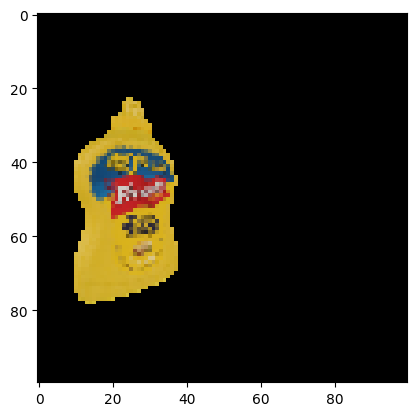

In [21]:
plt.imshow(images[0])

In [22]:
images[4].shape

(100, 100, 3)

In [23]:
## drawing a triangle of triangles in the scene

In [24]:
# mesh objects can be created from existing faces and vertex data
mesh = trimesh.Trimesh(vertices=[[0, 0, 0], [0, 0, 1], [0, 1, 0], [1, 1, 1], [1, 1, 2], [1, 2, 1]],
                       faces=[[0, 1, 2], [3, 4, 5]])

In [25]:
vertices = jnp.array(mesh.vertices) * 20.0
vertices = vertices - vertices.mean(0)
faces = jnp.array(mesh.faces)
#vertex_colors = jnp.array(mesh.visual.to_color().vertex_colors)[...,:3] / 255.0


rr.log(
    "/3d/mesh2",
    rr.Mesh3D(
        vertex_positions=mesh.vertices,
        indices=mesh.faces,
        vertex_colors=jnp.array([[255,0,0], [0,255,0], [255,0,0], [0,255,0], [255,0,0], [0,255,0]])
    ),
    timeless=True
)

In [26]:
# propose circle mask
# pick vertices on the mask
# make triangle based on texture
# generate movement proposals
# marginalize out over movement proposals to find the best features

In [27]:
indices = jnp.indices((height, width)).transpose(1,2,0)
# restrict to circles not within 3 of the edge
edge_buffer = triangle_boundary_radius = 5
indices = indices[edge_buffer:height-edge_buffer, edge_buffer:width-edge_buffer, :]
indices = indices.reshape(-1, 2)


In [28]:
key = jax.random.PRNGKey(15)
triangles = 500
choices = jax.random.choice(key, indices, shape=(triangles,))

In [29]:
# r = jax.random.uniform(key, shape=(triangles*2,)) * triangle_radius
# theta = jax.random.uniform(key, shape=(triangles*2,)) * 2 * jnp.pi

r = triangle_boundary_radius
theta_1 = jax.random.uniform(key, shape=(triangles,)) * 2 * jnp.pi / 3 
theta_2 = theta_1 + 2 * jnp.pi / 3 
theta_3 = theta_1 + 4 * jnp.pi / 3


In [30]:
vertex1 = jnp.round(choices + jnp.array([jnp.multiply(r,jnp.cos(theta_1)), jnp.multiply(r,jnp.sin(theta_1))]).T).astype(int)
vertex2 = jnp.round(choices + jnp.array([jnp.multiply(r,jnp.cos(theta_2)), jnp.multiply(r,jnp.sin(theta_2))]).T).astype(int)
vertex3 = jnp.round(choices + jnp.array([jnp.multiply(r,jnp.cos(theta_3)), jnp.multiply(r,jnp.sin(theta_3))]).T).astype(int)

In [31]:
vertices = jnp.array([vertex1, vertex2, vertex3]).transpose(1,0,2)

In [32]:
vertices.shape

(500, 3, 2)

In [33]:
vertices_flattened = vertices.reshape(-1,2)

In [34]:
# unproject point cloud and index the depth image

In [35]:
intrinsics = (width, height, fx, fy, cx, cy, near, far)
pc = unproject_depth(depths[4], intrinsics)

In [36]:
triangle_vertices = pc[tuple(vertices_flattened.T)]

In [37]:
triangle_indices = jnp.arange(0,300).reshape(100,3)

In [38]:
mesh = trimesh.Trimesh(vertices=triangle_vertices, faces=triangle_indices)

In [39]:
rr.log(
    "/3d/mesh3",
    rr.Mesh3D(
        vertex_positions=triangle_vertices,
        indices=triangle_indices,
        #vertex_colors=jnp.array([[255,0,0], [0,255,0], [255,0,0], [0,255,0], [255,0,0], [0,255,0]])
    ),
    timeless=True
)

In [40]:
rr.log(
    '/log_cloud',
    rr.Points3D(pc.reshape(-1,3)),
    timeless=True
)

In [41]:
 #rr.log('/pinhole', rr.Pinhole(camera_xyz=…))
rr.log("world", rr.ViewCoordinates.RIGHT_HAND_Z_UP, timeless=True)
rr.log(
    "world/xyz",
    rr.Arrows3D(
        vectors=[[1, 0, 0], [0, 1, 0], [0, 0, 1]],
        colors=[[255, 0, 0], [0, 255, 0], [0, 0, 255]],
    ),
)

In [42]:
# rr.log(
#     "world/xyz",
#     rr.Arrows3D(
#         vectors=pose.inv().as_matrix()[0:3,0:3],
#         colors=[[255, 0, 0], [0, 255, 0], [0, 0, 255]],
#     ),
# )

In [43]:
pose.as_matrix()[0:3,0:3]

Array([[-3.1622779e-01,  9.4868326e-01, -8.9406967e-08],
       [ 8.9406967e-08, -4.4703484e-08, -1.0000000e+00],
       [-9.4868326e-01, -3.1622779e-01, -2.9802322e-08]], dtype=float32)

In [44]:
# subtriangles
# recursively turn each triangle into four triangle 



In [45]:
triangle_vertices = jnp.array([triangle_vertices])
triangle_indices = jnp.array([triangle_indices])

In [46]:
len(triangle_vertices[0])

1500

In [47]:
vertices_flattened.shape

(1500, 2)

In [48]:
#jax routine to interpolate

#given a list of 4 vertex meshes, returns subdivided high-resolution mesh
 
def subdivide_triangles(triangle_vertices_list, triangle_indices_list, triangle_vertex_projections):
    # input triangle 
    num_triangle_vertices = len(triangle_vertices_list)
    num_triangles = len(triangle_indices_list)
    triangle_vertices_out = jnp.zeros((num_triangle_vertices*2, 3))
    triangle_vertex_projections_out = jnp.zeros((num_triangle_vertices*2, 2))
    
    triangle_vertices_out = triangle_vertices_out.at[0:num_triangle_vertices].set(triangle_vertices_list)
    triangle_indices_list_out = jnp.zeros((num_triangles*4, 3))
    triangle_vertex_projections_out = triangle_vertex_projections_out.at[0:num_triangle_vertices].set(triangle_vertex_projections)

    for ind, triangle_indices in enumerate(triangle_indices_list):
        p1, p2, p3 = triangle_vertices_list[triangle_indices]
        m1, m2, m3 = (p1 + p2)/2, (p2 + p3)/2, (p3 + p1)/2
        p1_pix, p2_pix, p3_pix = triangle_vertex_projections[triangle_indices]
        m1_pix, m2_pix, m3_pix = (p1_pix + p2_pix)/2, (p2_pix + p3_pix)/2, (p3_pix + p1_pix)/2
        
        triangle_vertices_out = triangle_vertices_out.at[num_triangle_vertices + 3*ind:num_triangle_vertices + 3*(ind+1)].set(jnp.array([m1, m2, m3]))
        triangle_vertex_projections_out = triangle_vertex_projections_out.at[num_triangle_vertices + 3*ind:num_triangle_vertices + 3*(ind+1)].set(jnp.array([m1_pix, m2_pix, m3_pix]))
        triangle_indices_list_out = triangle_indices_list_out.at[ind].set(np.array([num_triangle_vertices + 3*ind, num_triangle_vertices + 3*ind + 1, num_triangle_vertices + 3*ind + 2]))
        triangle_indices_list_out = triangle_indices_list_out.at[num_triangles + ind].set(np.array([triangle_indices[0], num_triangle_vertices + 3*ind, num_triangle_vertices + 3*ind + 2]))
        triangle_indices_list_out = triangle_indices_list_out.at[2*num_triangles + ind].set(np.array([triangle_indices[1], num_triangle_vertices + 3*ind, num_triangle_vertices + 3*ind + 1]))
        triangle_indices_list_out = triangle_indices_list_out.at[3*num_triangles + ind].set(np.array([triangle_indices[2], num_triangle_vertices + 3*ind + 1, num_triangle_vertices + 3*ind + 2]))

    return triangle_vertices_out, triangle_indices_list_out.astype(int), jnp.round(triangle_vertex_projections_out).astype(int)
        

# todo: grab color value from nearest point

# make these individual

In [49]:
sub_v, sub_i, sub_vf = subdivide_triangles(triangle_vertices[0], triangle_indices[0], vertices_flattened)


In [50]:
rr.log(
    "/3d/mesh4",
    rr.Mesh3D(
        vertex_positions=sub_v,
        indices=sub_i[0:100],
        #vertex_colors=jnp.array([[255,0,0], [0,255,0], [255,0,0], [0,255,0], [255,0,0], [0,255,0]])
    ),
    timeless=True
)

In [51]:
images[4][*sub_vf.T].shape

(3000, 3)

In [52]:
colors = jnp.round(images[4][*sub_vf.T]*255).astype(int)

In [53]:
rr.log(
    "/3d/mesh5",
    rr.Mesh3D(
        vertex_positions=sub_v,
        indices=sub_i,
        vertex_colors=colors
    ),
    timeless=True
)

In [54]:
sub_v.shape

(3000, 3)

In [55]:
sub_vf.shape

(3000, 2)

In [56]:
colors

Array([[0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       ...,
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0]], dtype=int32)

In [57]:
Pose.identity().as_matrix()[None,...].shape

(1, 4, 4)

In [ ]:
Pose.from_matrix(Pose.identity().as_matrix()[None,...])

In [59]:
ranges = jnp.array([[0, len(sub_i)]])
im_mesh, depth_mesh = renderer.render_attribute(Pose.from_matrix(Pose.identity().as_matrix()[None,...]), sub_v, sub_i, ranges, colors/255.0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


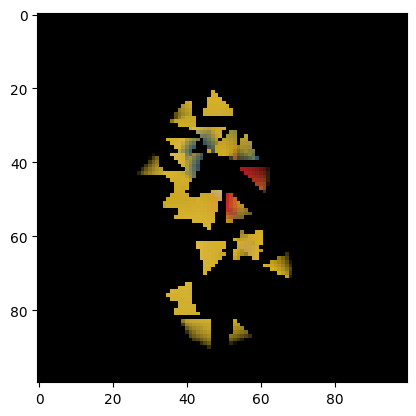

In [60]:
plt.imshow(im_mesh)

In [61]:
sub_i

Array([[1500, 1501, 1502],
       [1503, 1504, 1505],
       [1506, 1507, 1508],
       ...,
       [ 293, 1792, 1793],
       [ 296, 1795, 1796],
       [ 299, 1798, 1799]], dtype=int32)

In [62]:
len(sub_i)

400

In [63]:
sub_i[:,:,]

Array([[1500, 1501, 1502],
       [1503, 1504, 1505],
       [1506, 1507, 1508],
       ...,
       [ 293, 1792, 1793],
       [ 296, 1795, 1796],
       [ 299, 1798, 1799]], dtype=int32)

In [64]:
#v_pc = voxelize(pc.reshape(-1,3), 0.1)

In [65]:
pc.shape

(100, 100, 3)

In [66]:
images[4].shape

(100, 100, 3)

In [67]:
from b3d.utils import make_mesh_from_point_cloud_and_resolution
voxelized_mesh = make_mesh_from_point_cloud_and_resolution(pc.reshape(-1,3), images[4].reshape(-1,3), pc.reshape(-1,3)[:,2] / fx * 4.0)

In [68]:
voxelized_mesh

(Array([[-16.64    , -16.64    ,  15.36    ],
        [-16.64    , -16.64    ,  16.64    ],
        [-16.64    , -15.36    ,  15.36    ],
        ...,
        [ 16.32    ,  15.039999,  16.64    ],
        [ 16.32    ,  16.32    ,  15.36    ],
        [ 16.32    ,  16.32    ,  16.64    ]], dtype=float32),
 Array([[    1,     3,     0],
        [    4,     1,     0],
        [    0,     3,     2],
        ...,
        [79994, 79999, 79998],
        [79998, 79997, 79996],
        [79999, 79997, 79998]], dtype=int32),
 Array([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]], dtype=float32),
 Array([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]], dtype=float32))

In [69]:
rr.log(
    "/3d/mesh6",
    rr.Mesh3D(
        vertex_positions=voxelized_mesh[0],
        indices=voxelized_mesh[1],
        vertex_colors=colors[2]
    ),
    timeless=True
)

In [70]:
# determine if point is inside triangle
def sign(p1, p2, p3):
    return (p1[0] - p3[0]) * (p2[1] - p3[1]) - (p2[0] - p3[0]) * (p1[1] - p3[1])

def point_in_triangle(pt, v1, v2, v3):
    d1 = sign(pt, v1, v2)
    d2 = sign(pt, v2, v3)
    d3 = sign(pt, v3, v1)

    has_neg = (d1 < 0) | (d2 < 0) | (d3 < 0)
    has_pos = (d1 > 0) | (d2 > 0) | (d3 > 0)

    return jnp.logical_not(jnp.array((has_neg & has_pos)))

point_in_triangles_vec = jax.vmap(point_in_triangle, in_axes=(None, 0, 0, 0))
points_in_triangles_vec = jax.vmap(point_in_triangles_vec, in_axes=(0, None, None, None))

In [71]:
indices = jnp.indices((height, width)).transpose(1,2,0).reshape(-1,2)
ptv = points_in_triangles_vec(indices, vertex1, vertex2, vertex3)

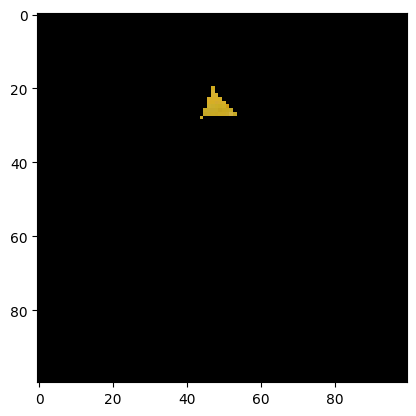

In [72]:
plt.imshow(np.multiply(images[4],ptv[:,10].reshape(100,100)[:,:,None]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


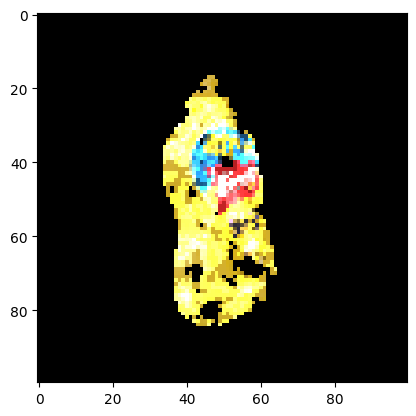

In [73]:
plt.imshow(np.multiply(images[4],jnp.sum(ptv, axis=1).reshape(100,100)[:,:,None]))

In [74]:
test_triangle = ptv[:,12].reshape(100,100)

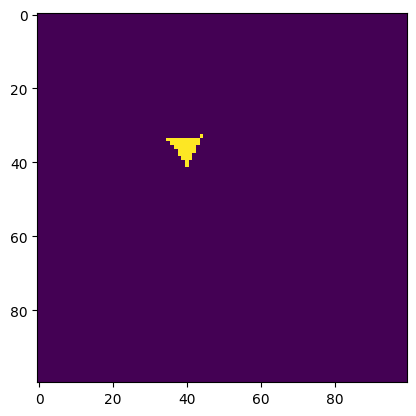

In [75]:
plt.imshow(test_triangle)

In [76]:
# voxelize the features into clouds 

In [77]:
v, f, vc, fc = make_mesh_from_point_cloud_and_resolution(pc[test_triangle], images[4][test_triangle], pc[test_triangle][:,2] / fx * 4.0)

In [79]:
im_feat, depth_feat = renderer.render_attribute(Pose.from_matrix(Pose.identity().as_matrix()[None,...]), v, f, ranges = jnp.array([[0, len(f)]]),
                                                 attributes=vc)

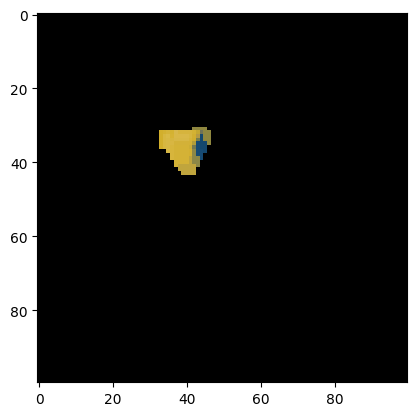

In [80]:
plt.imshow(im_feat)

In [81]:
rr.log(
    "/3d/mesh6",
    rr.Mesh3D(
        vertex_positions=v,
        indices=f,
        vertex_colors=vc
    ),
    timeless=True
)

In [82]:
# take mesh, generate motion proposal, and score in parallel

In [83]:
object_library = b3d.MeshLibrary.make_empty_library()

In [84]:
object_library.add_object(v, f, vc)

In [85]:
object_library.faces

Array([[  1,   3,   0],
       [  4,   1,   0],
       [  0,   3,   2],
       ...,
       [298, 303, 302],
       [302, 301, 300],
       [303, 301, 302]], dtype=int32)

In [86]:
for i in range(ptv.shape[1]):
    test_triangle = ptv[:,i].reshape(100,100)
    v, f, vc, fc = make_mesh_from_point_cloud_and_resolution(pc[test_triangle], images[4][test_triangle], pc[test_triangle][:,2] / fx * 4.0)
    object_library.add_object(v, f, vc)

In [87]:
object_library.faces.shape

(220416, 3)

In [88]:
f.shape

(444, 3)

In [89]:
model = b3d.model_multiobject_gl_factory(renderer)

In [90]:
object_library.attributes.shape

(146944, 3)

In [91]:
object_library.ranges

Array([[     0,    456],
       [   456,    444],
       [   900,    444],
       ...,
       [219108,    408],
       [219516,    456],
       [219972,    444]], dtype=int32)

In [92]:
object_library.ranges[0]

Array([  0, 456], dtype=int32)

In [93]:
object_library.vertices.shape

(146944, 3)

In [94]:
library_obj_indices_to_render = jnp.empty((0,), dtype=int)
object_identity=11
library_obj_indices_to_render = jnp.concatenate((library_obj_indices_to_render, jnp.array([object_identity])))


In [95]:
library_obj_indices_to_render

Array([11], dtype=int32)

In [96]:
object_library.vertices, object_library.faces, object_library.ranges[library_obj_indices_to_render] * (library_obj_indices_to_render >= 0).reshape(-1,1), object_library.attributes

(Array([[-0.40442047, -0.96049863,  2.4265227 ],
        [-0.40442047, -0.96049863,  2.6287332 ],
        [-0.40442047, -0.75828844,  2.4265227 ],
        ...,
        [-5.7599998 ,  7.36      , 16.64      ],
        [-5.7599998 ,  8.64      , 15.36      ],
        [-5.7599998 ,  8.64      , 16.64      ]], dtype=float32),
 Array([[     1,      3,      0],
        [     4,      1,      0],
        [     0,      3,      2],
        ...,
        [146938, 146943, 146942],
        [146942, 146941, 146940],
        [146943, 146941, 146942]], dtype=int32),
 Array([[4800,  444]], dtype=int32),
 Array([[0.56117225, 0.53203773, 0.25071576],
        [0.56117225, 0.53203773, 0.25071576],
        [0.56117225, 0.53203773, 0.25071576],
        ...,
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ]], dtype=float32))

In [101]:
im_feat, depth_feat = renderer.render_attribute(Pose.from_matrix(Pose.identity().as_matrix()[None,...]), object_library.vertices, object_library.faces, object_library.ranges[library_obj_indices_to_render] * (library_obj_indices_to_render >= 0).reshape(-1,1), object_library.attributes)

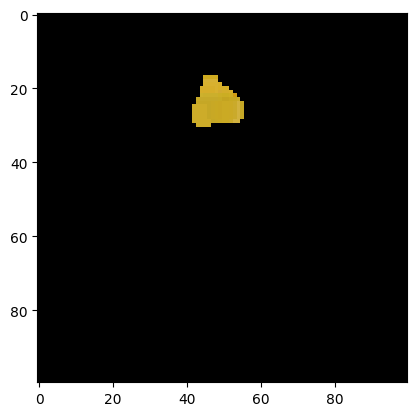

In [102]:
plt.imshow(im_feat)

In [103]:
library_obj_indices_to_render

Array([11], dtype=int32)

: 